# Predicting Heart Disease with Stacking (Logistic + XGBoost)

This notebook shows how I used **stacking** to predict heart disease in the Kaggle *Playground Series – S6E2* competition.  
The stacking setup is **Logistic Regression** to **XGBoost**.

In this notebook I will:

- Load and inspect the heart disease dataset.
- Build a clean **train/validation split** and preprocessing pipeline:
  - standardize numerical features using statistics from the training set only,
  - one-hot encode categorical features,
- Train a **Logistic Regression** as a baseline model:
  - tune the regularization strength `C` with Stratified K-Fold and ROC AUC,
  - use it both as a standalone model and as a building block for stacking.
- Implement **out-of-fold (OOF) predictions** from Logistic Regression:
  - for each fold, fit the model on 4/5 of the data and predict on the held-out 1/5,
  - collect these OOF probabilities into a new feature (`logit_oof`) for every training row,
  - fit a final Logistic on the full training set and use it to get probabilities for the validation set.


This allows us to use Logistic Regression not only as a classifier, but also as a learned feature that summarizes the “linear risk” of heart disease.

Then:

- Train **XGBoost on the original features only** and evaluate it on the validation set with ROC AUC.
- Train **XGBoost on the stacked features** (original features + `logit_oof`) and see whether the ROC AUC improves.
- Plot **ROC curves** and **calibration curves** for Logistic vs XGBoost (with and without stacking).

The focus is:

- showing how stacking is implemented with OOF predictions,
- comparing XGBoost alone vs XGBoost + Logistic features,
- keeping the whole approach **simple and reproducible**.

## Data processing

In [1]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s6e2/train.csv")
print(f"Shape: {train.shape}")
train.head()

Shape: (630000, 15)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [4]:
train["Heart Disease"].value_counts(normalize=True)

Heart Disease
Absence     0.55166
Presence    0.44834
Name: proportion, dtype: float64

In [5]:
train.drop('id', axis=1, inplace=True)

train["HeartDisease"] = (train["Heart Disease"] == "Presence").astype(int)
train = train.drop(columns=["Heart Disease"])
train["HeartDisease"].value_counts(normalize=True)

HeartDisease
0    0.55166
1    0.44834
Name: proportion, dtype: float64

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,630000.0,54.136706,8.256301,29.0,48.0,54.0,60.0,77.0
Sex,630000.0,0.714735,0.451541,0.0,0.0,1.0,1.0,1.0
Chest pain type,630000.0,3.312752,0.851615,1.0,3.0,4.0,4.0,4.0
BP,630000.0,130.497433,14.975802,94.0,120.0,130.0,140.0,200.0
Cholesterol,630000.0,245.011814,33.681581,126.0,223.0,243.0,269.0,564.0
FBS over 120,630000.0,0.079987,0.271274,0.0,0.0,0.0,0.0,1.0
EKG results,630000.0,0.981660,0.998783,0.0,0.0,0.0,2.0,2.0
Max HR,630000.0,152.816763,19.112927,71.0,142.0,157.0,166.0,202.0
Exercise angina,630000.0,0.273725,0.445870,0.0,0.0,0.0,1.0,1.0
ST depression,630000.0,0.716028,0.948472,0.0,0.0,0.1,1.4,6.2


HeartDisease               1.000000
Thallium                   0.605776
Chest pain type            0.460684
Exercise angina            0.441864
Number of vessels fluro    0.438604
ST depression              0.430641
Slope of ST                0.415050
Sex                        0.342446
EKG results                0.218961
Age                        0.212091
Cholesterol                0.082753
FBS over 120               0.033570
BP                        -0.005181
Max HR                    -0.440985
Name: HeartDisease, dtype: float64


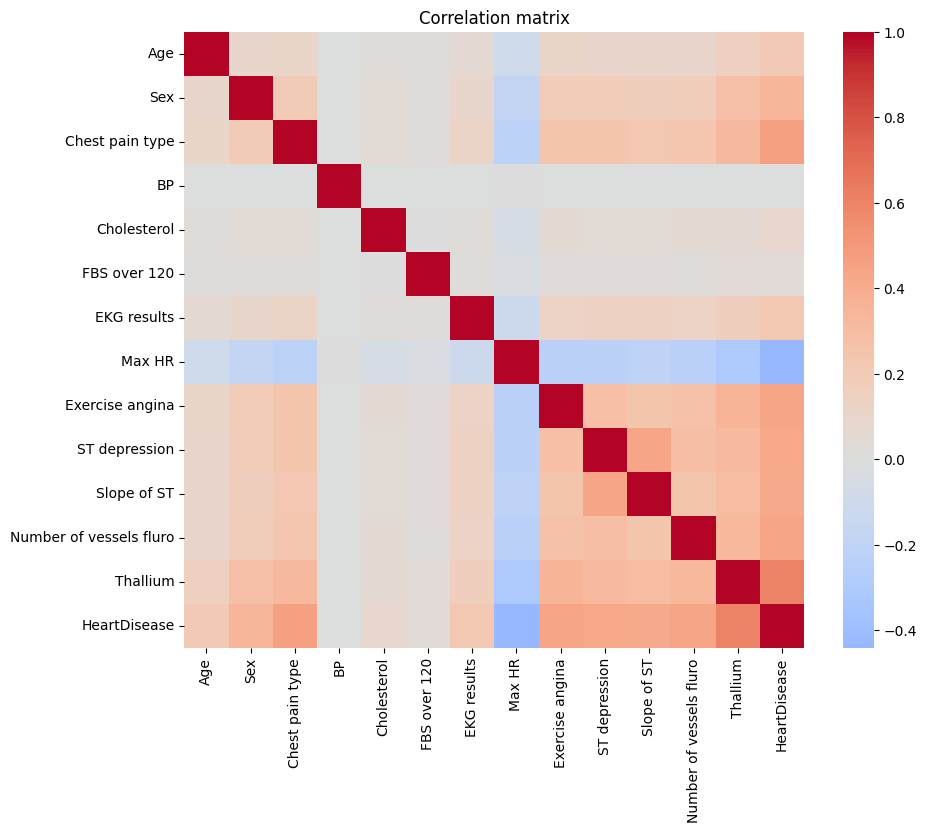

In [7]:
corr = train.corr(numeric_only=True)
print(corr["HeartDisease"].sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation matrix")
plt.show()

I split the data before scaling because otherwise information from the validation set would influence the mean and standard deviation, and the validation performance would no longer reflect true unseen data.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

target = "HeartDisease"
features = [c for c in train.columns if c not in [target]]

num_cols = [
    "Age",
    "BP",
    "Cholesterol",
    "Max HR",
    "ST depression",
]

cat_cols = [c for c in features if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
Categorical: ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


In [9]:
X = train[features]
y = train[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
means = X_train[num_cols].mean()
stds = X_train[num_cols].std()

X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()

X_train_scaled[num_cols] = (X_train_scaled[num_cols] - means) / stds
X_valid_scaled[num_cols] = (X_valid_scaled[num_cols] - means) / stds

#One hot
X_train_final = pd.get_dummies(
    X_train_scaled,
    columns=cat_cols,
    drop_first=False
)

X_valid_final = pd.get_dummies(
    X_valid_scaled,
    columns=cat_cols,
    drop_first=False
)

X_valid_final = X_valid_final.reindex(columns=X_train_final.columns, fill_value=0)

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV

X = X_train_final
y = y_train

logit = LogisticRegression(max_iter=1000, solver="lbfgs")

param_grid = {
    "C": [0.1, 0.3, 1.0, 3.0, 10.0]
}

cv_logit = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_logit = GridSearchCV(
    estimator=logit,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_logit,
    n_jobs=-1
)

grid_logit.fit(X, y)

print("Best Logistic C:", grid_logit.best_params_)
print("Best Logistic CV AUC:", grid_logit.best_score_)

best_logit = grid_logit.best_estimator_

Best Logistic C: {'C': 1.0}
Best Logistic CV AUC: 0.9526748556507227


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

X = X_train_final
y = y_train

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_logit = np.zeros(len(X))

for train_idx, val_idx in kf.split(X, y):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr = y.iloc[train_idx]

    model_fold = LogisticRegression(
        max_iter=1000,
        solver=best_logit.solver,
        C=best_logit.C
    )
    model_fold.fit(X_tr, y_tr)
    oof_logit[val_idx] = model_fold.predict_proba(X_val)[:, 1]


best_logit.fit(X, y)

X_stack_train = X.copy()
X_stack_valid = X_valid_final.copy()

valid_logit = best_logit.predict_proba(X_valid_final)[:, 1]

X_stack_train["logit_oof"] = oof_logit
X_stack_valid["logit_oof"] = valid_logit

## XGBoost

In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# XGBoost base (senza logit_oof)
xgb_base = XGBClassifier(
    n_estimators=1200,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    learning_rate=0.01,
    random_state=42,
    objective="binary:logistic",
    n_jobs=-1
)

xgb_base.fit(X_train_final, y_train)
valid_proba_base = xgb_base.predict_proba(X_valid_final)[:, 1]
auc_base = roc_auc_score(y_valid, valid_proba_base)
print(f"XGBoost base - valid AUC: {auc_base:.4f}")

# XGBoost with stacking
xgb_stack = XGBClassifier(
    n_estimators=1200,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    learning_rate=0.01,
    random_state=42,
    objective="binary:logistic",
    n_jobs=-1
)

xgb_stack.fit(X_stack_train, y_train)
valid_proba_stack = xgb_stack.predict_proba(X_stack_valid)[:, 1]
auc_stack = roc_auc_score(y_valid, valid_proba_stack)
print(f"XGBoost with stacking - valid AUC: {auc_stack:.4f}")

XGBoost base - valid AUC: 0.9550
XGBoost with stacking - valid AUC: 0.9551


| Model | AUC ROC |
|-|-|
| Logistic Regression| 0.9527|
| XGBoost| 0.9550|
| XGBoost + Logistic (stacked)| 0.9551|

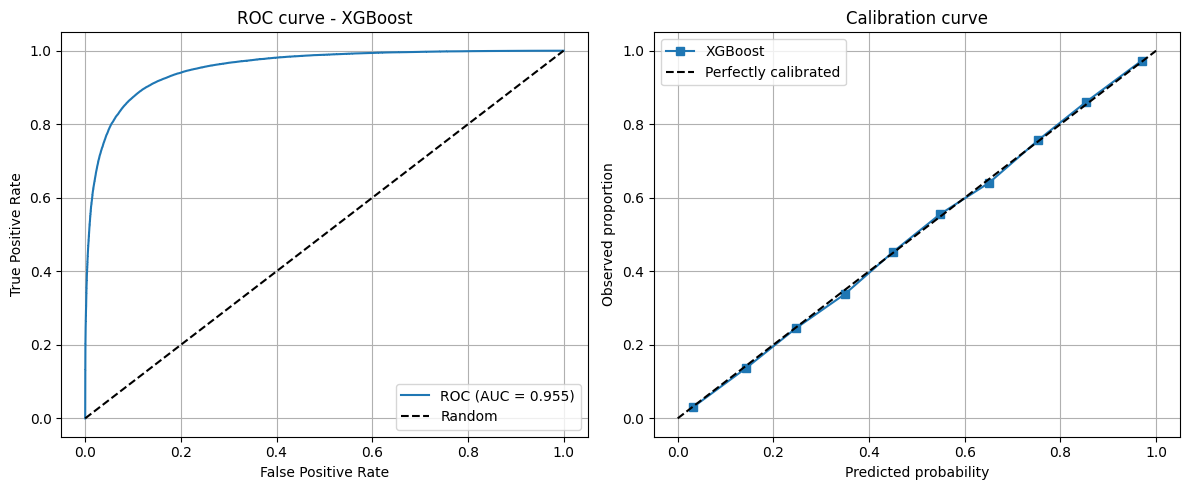

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Predictions
y_valid_proba = xgb_stack.predict_proba(X_stack_valid)[:, 1]
valid_auc = roc_auc_score(y_valid, y_valid_proba)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_valid, y_valid_proba)

# Calibration curve
prob_true, prob_pred = calibration_curve(y_valid, y_valid_proba, n_bins=10)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC
axes[0].plot(fpr, tpr, label=f"ROC (AUC = {valid_auc:.3f})")
axes[0].plot([0, 1], [0, 1], "k--", label="Random")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC curve - XGBoost")
axes[0].legend()
axes[0].grid(True)

# Calibration
axes[1].plot(prob_pred, prob_true, "s-", label="XGBoost")
axes[1].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
axes[1].set_xlabel("Predicted probability")
axes[1].set_ylabel("Observed proportion")
axes[1].set_title("Calibration curve")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

The ROC curve shows excellent discrimination (AUC ≈ 0.955), and the calibration curve lies almost perfectly on the diagonal (predicted probabilities very well calibrated on the validation set).

## Submission

In [14]:
# Preprocessing
test = pd.read_csv("/kaggle/input/playground-series-s6e2/test.csv")
X_test = test[features].copy()

X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = (X_test_scaled[num_cols] - means) / stds

X_test_final = pd.get_dummies(
    X_test_scaled,
    columns=cat_cols,
    drop_first=False
)
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

test_logit = best_logit.predict_proba(X_test_final)[:, 1]

X_stack_test = X_test_final.copy()
X_stack_test["logit_oof"] = test_logit

# Training
xgb_stack_final = XGBClassifier(
    n_estimators=1200,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    learning_rate=0.01,
    random_state=42,
    objective="binary:logistic",
    n_jobs=-1
)

xgb_stack_final.fit(X_stack_train, y_train)

# Prediction
test_pred = xgb_stack_final.predict_proba(X_stack_test)[:, 1]

submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": test_pred
})
submission.to_csv("submission.csv", index=False)